In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Reading in Data

In [2]:
df = pd.read_csv('data.csv')

### Understanding and Visualizing the data

In [3]:
#based on this we can see that we have 12 columns to work with so 11 for input and 1 for output
df.shape

(614, 13)

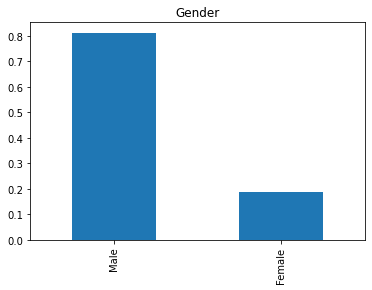

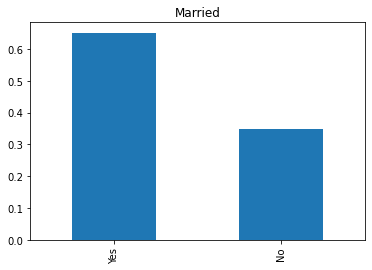

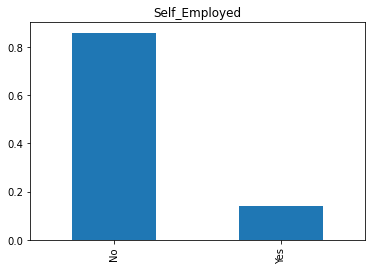

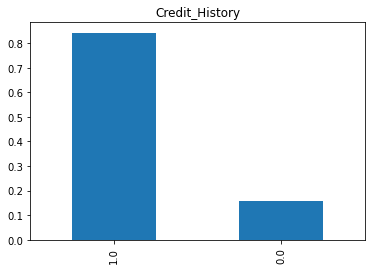

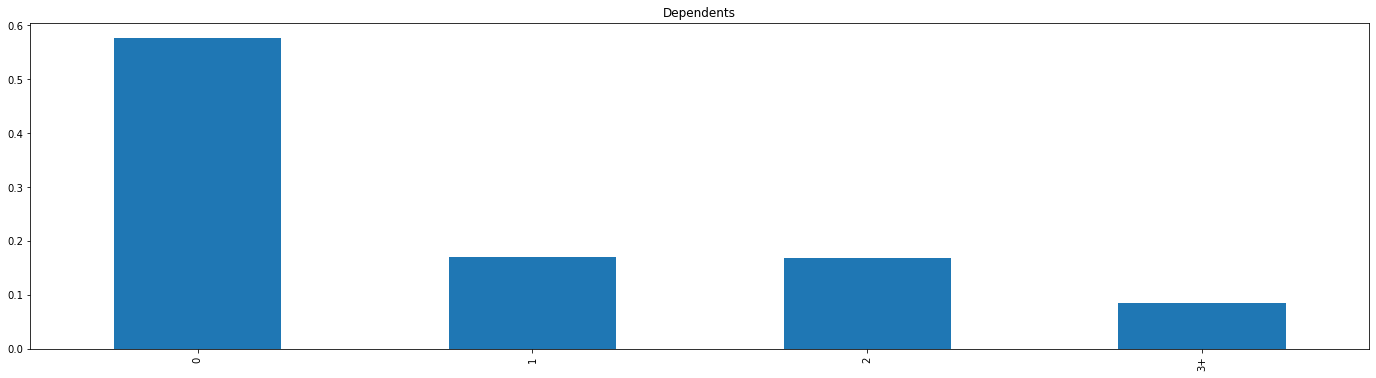

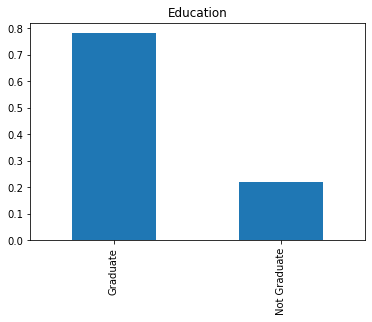

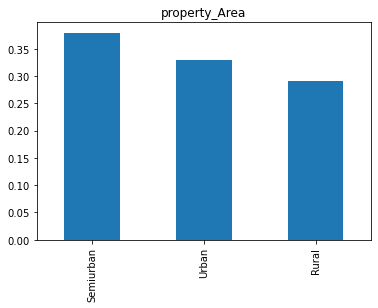

In [4]:
#graphs to visualize the categorical variables
df['Gender'].value_counts(normalize=True).plot.bar(title='Gender')
plt.show()
df['Married'].value_counts(normalize=True).plot.bar(title='Married')
plt.show()
df['Self_Employed'].value_counts(normalize=True).plot.bar(title='Self_Employed')
plt.show()
df['Credit_History'].value_counts(normalize=True).plot.bar(title='Credit_History')
plt.show()
df['Dependents'].value_counts(normalize=True).plot.bar(figsize=(24,6), title='Dependents')
plt.show()
df['Education'].value_counts(normalize=True).plot.bar(title='Education')
plt.show()
df['property_Area'].value_counts(normalize=True).plot.bar(title='property_Area')
plt.show()

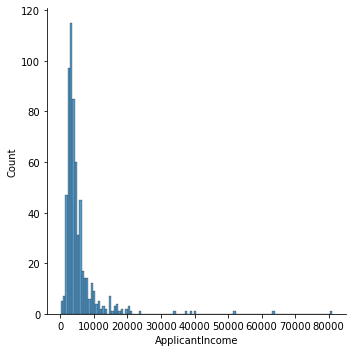

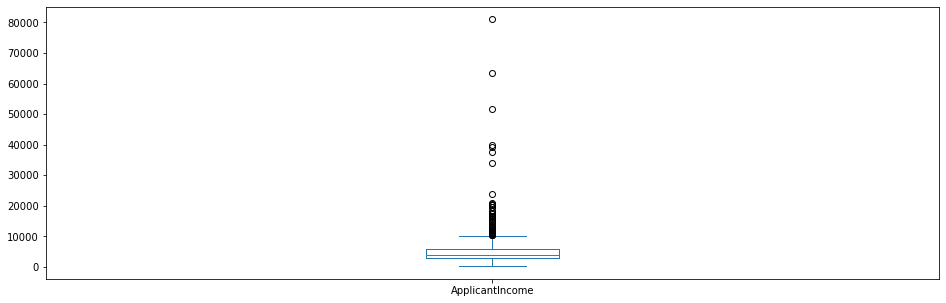

In [5]:
#graphs to visualize the numerical features
sns.displot(df['ApplicantIncome'])
plt.show()
df['ApplicantIncome'].plot.box(figsize=(16,5))
plt.show()

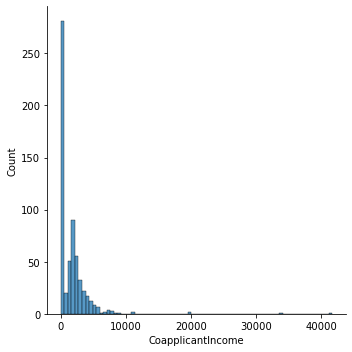

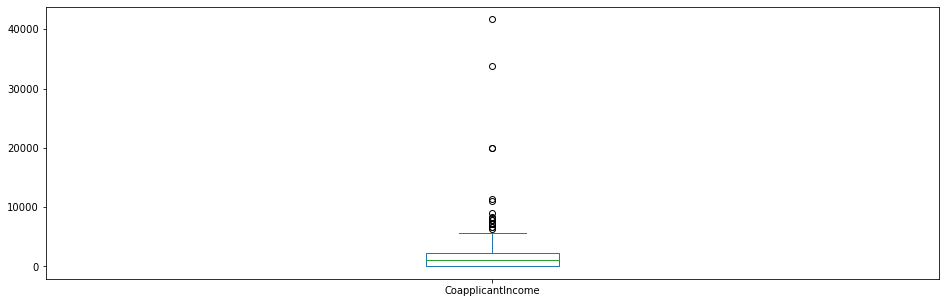

In [6]:
sns.displot(df['CoapplicantIncome'])
plt.show()
df['CoapplicantIncome'].plot.box(figsize=(16,5))
plt.show()

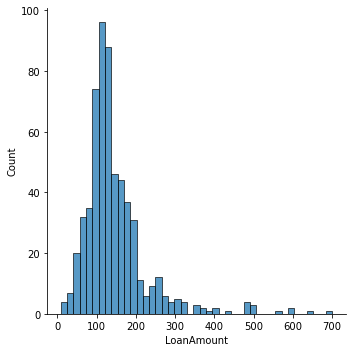

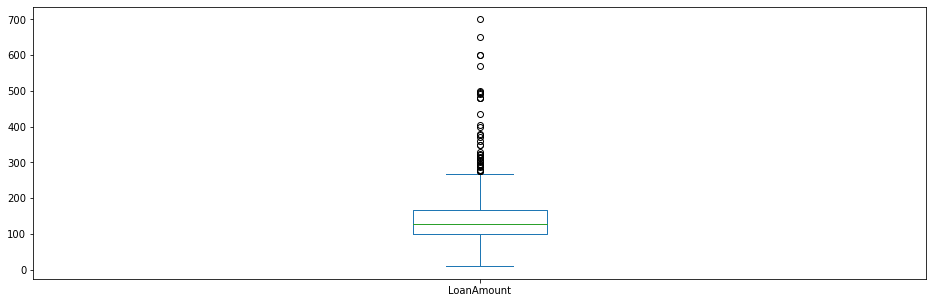

In [7]:
sns.displot(df['LoanAmount'])
plt.show()
df['LoanAmount'].plot.box(figsize=(16,5))
plt.show()

### filling in the missing values

In [8]:
#this code is filling in the missing values of applicant income so anything else that needs 
#to be filled in we will use this place for it
df[['ApplicantIncome', 'CoapplicantIncome','LoanAmount']] = df[['ApplicantIncome', 
'CoapplicantIncome', 'LoanAmount']].fillna(df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']].median())
#fills in the missign values with the most common for the categorical columns
df['Education'].fillna(df['Education'].mode()[0], inplace = True)
df['Married'].fillna(df['Married'].mode()[0], inplace = True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace = True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace = True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace = True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace = True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace = True)


### Covnerting Categorical values to Numerical

In [9]:
#this converts gender into binary
g = pd.get_dummies(df['Gender'])
df = pd.concat((df, g), axis = 1)
df = df.drop(['Female'], axis = 1)
df = df.drop(['Gender'], axis = 1)
df = df.rename(columns = {'Male': 'Gender'})
#this converts the loan status to binary
ls = pd.get_dummies(df['Loan_Status'])
df = pd.concat((df, ls), axis=1)
df = df.drop(['N'], axis = 1)
df = df.drop(['Loan_Status'], axis = 1)
df = df.rename(columns = {'Y': 'Loan_Status'})
#this converts the married to binary
m = pd.get_dummies(df['Married'])
df = pd.concat((df, m), axis=1)
df = df.drop(['No'], axis = 1)
df = df.drop(['Married'], axis = 1)
df = df.rename(columns = {'Yes': 'Married'})
#this converts education into binary
ed = pd.get_dummies(df['Education'])
df = pd.concat((df, ed), axis=1)
df = df.drop(['Not Graduate'], axis = 1)
df = df.drop(['Education'], axis = 1)
df = df.rename(columns = {'Yes': 'Education'})
#this converts self employed into binary
ep = pd.get_dummies(df['Self_Employed'])
df = pd.concat((df, ep), axis=1)
df = df.drop(['No'], axis = 1)
df = df.drop(['Self_Employed'], axis = 1)
df = df.rename(columns = {'Yes': 'Self_Employed'})
#creating the hot encoder for the property area since, its not ordinal we 
#cant jsut integer encode it we have to use a different method
#like one hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['property_Area']]).toarray())
df = df.join(encoder_df)
df.rename(columns = {0:'Rural', 1:'Semiurban', 2:'Urban'}, inplace = True)
#since dependents is ordinal where order matters we can easily use integer encoding for 
#it, so we used labelencoder
le = LabelEncoder()
df['Dependents'] = le.fit_transform(df.Dependents)

In [10]:
#fixing dataframe 
gcol = df.pop('Gender')
df.insert(loc = 1, column = 'Gender', value = gcol)
mcol = df.pop('Married')
df.insert(loc = 2, column = 'Married', value = mcol)
ecol = df.pop('Graduate')
df.insert(loc = 3, column = 'Education', value = ecol)
secol = df.pop('Self_Employed')
df.insert(loc = 4, column = 'Self_Employed', value = secol)
lscol = df.pop('Loan_Status')
df.insert(loc = 15, column = 'Loan_Status', value = lscol)

In [11]:
df

,Loan_ID,Gender,Married,Education,Self_Employed,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Rural,Semiurban,Urban,Loan_Status
0,LP001002,1,0,1,0,0,5849.0,0.0,128.0,360.0,1.0,Urban,0.0,0.0,1.0,1
1,LP001003,1,1,1,0,1,3806.0,1508.0,128.0,360.0,1.0,Rural,1.0,0.0,0.0,0
2,LP001005,1,1,1,1,0,3000.0,0.0,66.0,360.0,1.0,Urban,0.0,0.0,1.0,1
3,LP001006,1,1,0,0,0,2583.0,2358.0,120.0,360.0,1.0,Urban,0.0,0.0,1.0,1
4,LP001008,1,0,1,0,0,6000.0,0.0,141.0,360.0,1.0,Urban,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,1,0,0,2900.0,0.0,71.0,360.0,1.0,Rural,1.0,0.0,0.0,1
610,LP002979,1,1,1,0,3,4106.0,0.0,40.0,180.0,1.0,Rural,1.0,0.0,0.0,1
611,LP002983,1,1,1,0,1,8072.0,240.0,253.0,360.0,1.0,Urban,0.0,0.0,1.0,1
612,LP002984,1,1,1,0,2,7583.0,0.0,187.0,360.0,1.0,Urban,0.0,0.0,1.0,1


### Feature Engineering

#### Feature Correlation HeatMap

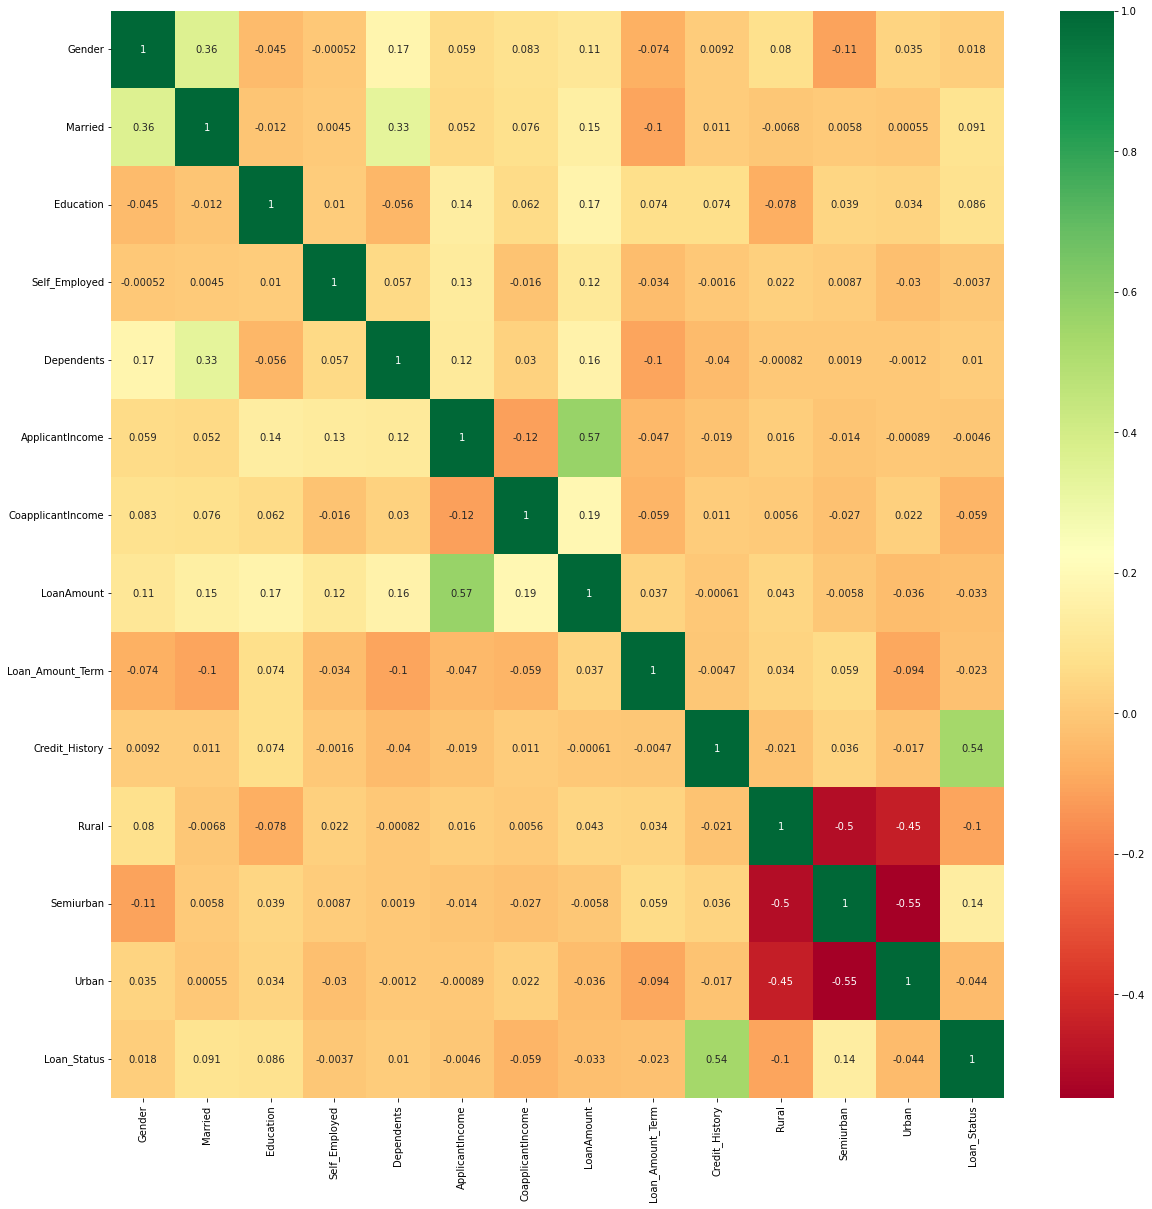

In [12]:
#graph to see the feature correlation
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### SelectKBest to Find best Features

In [13]:
Xdata = df[['Dependents', 'ApplicantIncome', 'CoapplicantIncome','LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married', 'Education', 'Self_Employed', 'Rural', 'Semiurban', 'Urban']]
Ydata = df[['Loan_Status']]

In [14]:
#preparing the selectkbest
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(Xdata,Ydata)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(Xdata.columns)
#creates a quick graph to show the features and their score
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']

In [15]:
featureScores

,Features,Score
0,Dependents,0.085953
1,ApplicantIncome,89.954326
2,CoapplicantIncome,11446.899386
3,LoanAmount,32.821655
4,Loan_Amount_Term,3.778554
5,Credit_History,26.005877
6,Gender,0.036234
7,Married,1.782425
8,Education,0.988390
9,Self_Employed,0.007285


In [16]:
print(featureScores.nlargest(10,'Score'))

             Features         Score
2   CoapplicantIncome  11446.899386
1     ApplicantIncome     89.954326
3          LoanAmount     32.821655
5      Credit_History     26.005877
11          Semiurban      7.103093
10              Rural      4.410584
4    Loan_Amount_Term      3.778554
7             Married      1.782425
8           Education      0.988390
12              Urban      0.783946


#### Feature extraction and selection

In [17]:
#feature extraction
df['Total_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
#feature selection
df = df.drop(['Loan_ID'], axis = 1)
df = df.drop(['ApplicantIncome'], axis = 1)
df = df.drop(['CoapplicantIncome'], axis = 1)
df = df.drop(['property_Area'], axis = 1)
df = df.drop(['Gender'], axis = 1)
df = df.drop(['Self_Employed'], axis = 1)
df = df.drop(['Dependents'], axis = 1)
df = df.drop(['Urban'], axis = 1)
df = df.drop(['Semiurban'],axis = 1)
df = df.drop(['Rural'], axis = 1)
tcol = df.pop('Total_income')
df.insert(loc = 2 ,column = 'Total_income', value = tcol)

In [18]:
df

,Married,Education,Total_income,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,0,1,5849.0,128.0,360.0,1.0,1
1,1,1,5314.0,128.0,360.0,1.0,0
2,1,1,3000.0,66.0,360.0,1.0,1
3,1,0,4941.0,120.0,360.0,1.0,1
4,0,1,6000.0,141.0,360.0,1.0,1
...,...,...,...,...,...,...,...
609,0,1,2900.0,71.0,360.0,1.0,1
610,1,1,4106.0,40.0,180.0,1.0,1
611,1,1,8312.0,253.0,360.0,1.0,1
612,1,1,7583.0,187.0,360.0,1.0,1


### Logistic Regression Model

In [19]:
#over here we will be creating new dataframes to work with x and y, x being input and y being output
x = df[['Total_income','LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Married', 'Education']]
#x = df[['Total_income','LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Married', 'Education', 'Rural','Semiurban', 'Urban'
y = df[['Loan_Status']]

In [20]:
#here we will split the the x and y and create the testing and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [21]:
model = LogisticRegression()

In [22]:
model.fit(x_train, y_train.values.ravel())

LogisticRegression()

In [23]:
ypredTest = model.predict(x_test)
ypredtrainData = model.predict(x_train)

### Confusion Matrix

In [24]:
#confusion matrix for testing data
confusion_matrix(y_test, ypredTest, labels = (1,0))

array([[89,  1],
       [19, 14]], dtype=int64)

In [25]:
#measures the accuracy of how well the algorithm performs with the traiining data
accuracyTrain = accuracy_score(y_train, ypredtrainData)
#measruign the accuracy, is measuirng how well it predict the ytest output agians the actual predicitons
#measuirng accruay of test data
accuracyTest = accuracy_score(y_test ,ypredTest)

In [26]:
print("accuracy for model on training data")
accuracyTrain.round(3)

accuracy for model on training data


0.8

In [27]:
print("accuracy for model on testing data")
accuracyTest.round(2)

accuracy for model on testing data


0.84

In [28]:
#gives us our precsion score
precision_score(y_test, ypredTest).round(3)

0.824

In [29]:
#gives us our recall score
recall_score(y_test, ypredTest).round(2)

0.99

In [30]:
#calcualtes f1 score for the test data
evaluation = f1_score(y_test, ypredTest)
evaluation.round(3)

0.899